# Constructing drive time based service areas
This sample shows how the `network` module of the ArcGIS API for Python can be used to construct service areas. In this sample, we generate service areas for two of the fire stations in central Tokyo, Japan. We later observe how the service area varies by time of day for a fire station in the city of Los Angeles.

### Service areas
A network service area is a region that encompasses all accessible streets (that is, streets that are within a specified impedance). For instance, the 5-minute service area for a point on a network includes all the streets that can be reached within five minutes from that point.

Service areas also help evaluate accessibility. Concentric service areas show how accessibility varies. Once service areas are created, you can use them to identify how much land, how many people, or how much of anything else is within the neighborhood or region.

![](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/GUID-0166E6A5-CDEC-4A03-A022-F4A6EB7F9EAD-web.png)

Service area solver provides functionality for finding out how far a vehicle could go within a specified time or distance limit. 

## Connect to the GIS
Establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. To be able to run the code in this sample notebook, you would need to provide credentials of a user within an ArcGIS Online organization.

In [1]:
from datetime import datetime
from IPython.display import HTML
import pandas as pd
from arcgis.gis import GIS

user_name = 'arcgis_python'
password = 'P@ssword123'
my_gis = GIS('https://www.arcgis.com', user_name, password)

### Create a Network Layer
To perform any network analysis (such as finding the closest facility, the best route between multiple stops, or service area around a facility), you would need to create a `NetworkLayer` object. In this sample, since we are creating service areas, we need to create a `ServiceAreaLayer` which is a type of `NetworkLayer`.

To create any `NetworkLayer` object, you would need to provide the URL to the appropriate network analysis service. Hence, in this sample, we provide a `serviceArea` URL to create a `ServiceAreaLayer` object. 

Since all ArcGIS Online organizations already have access to those routing services, you can access this URL through the `GIS` object's `helperServices` property. If you have your own ArcGIS Server based map service with network analysis capability enabled, you would need to provide the URL for this service.

Let us start by importing the `network` module

In [3]:
import arcgis.network as network

In [4]:
service_area_url = my_gis.properties.helperServices.serviceArea.url
service_area_url

'https://route.arcgis.com/arcgis/rest/services/World/ServiceAreas/NAServer/ServiceArea_World'

In [9]:
sa_layer = network.ServiceAreaLayer(service_area_url, gis=my_gis)

## Create fire station facility layer

We obtained the coordinates of two fire stations in Tokyo. We construct `Feature` and `FeatureSet` objects to represent them.

In [6]:
fire_station_1_coord = '139.546910,35.695729'
fire_station_2_coord = '139.673726,35.697988'

from arcgis.features import Feature, FeatureSet

f1 = Feature(geometry={'x':float(fire_station_1_coord.split(',')[0]),
                      'y':float(fire_station_1_coord.split(',')[1])})

f2 = Feature(geometry={'x':float(fire_station_2_coord.split(',')[0]),
                      'y':float(fire_station_2_coord.split(',')[1])})

fire_station_fset = FeatureSet([f1,f2], geometry_type='esriGeometryPoint', 
                            spatial_reference={'latestWkid': 4326})

Let us display the fire stations on a map


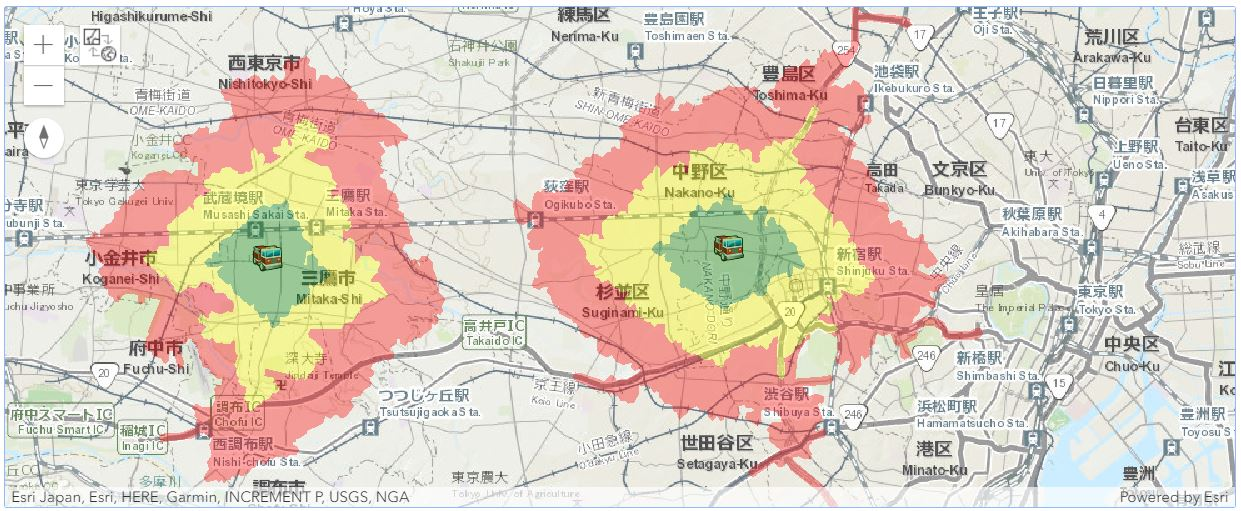

In [2]:
map1 = my_gis.map('Tokyo', zoomlevel=12)
map1

In [31]:
fire_truck_symbol = {"type":"esriPMS",
                     "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/FireTruck.png",
                     "contentType": "image/png", "width":20, "height":20}

map1.draw(fire_station_fset, symbol=fire_truck_symbol)

## Compute the service area
To compute the service area (area accessible to each facility based on drive times), we use the `solve_service_area()` method of a `ServiceAreaLayer` object. As the fire trucks will be travelling away from the stations, we need to specify the direction of travel in the `travel_direction` parameter. Also, since for the type of vehicles is fire trucks, we could specify the travel mode to make it easier to supply all other related parameters.

In [10]:
travel_modes = sa_layer.retrieve_travel_modes()
truck_mode = [t for t in travel_modes['supportedTravelModes'] if t['name'] == 'Trucking Time'][0]

result = sa_layer.solve_service_area(fire_station_fset, default_breaks=[5,10,15], 
                                     travel_direction='esriNATravelDirectionFromFacility',
                                     travel_mode=truck_mode)

#### Read the result back as a `FeatureSet`
The `result` variable contains the service area as a dictionary. We inspect its keys and construct `Feature` and `FeatureSet` objects out of it to display in the map

In [11]:
result.keys()

dict_keys(['messages', 'saPolygons'])

In [12]:
result['saPolygons'].keys()

dict_keys(['geometryType', 'fieldAliases', 'spatialReference', 'features'])

In [17]:
poly_feat_list = []
for polygon_dict in result['saPolygons']['features']:
    f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
    poly_feat_list.append(f1)

In [18]:
service_area_fset = FeatureSet(poly_feat_list, 
                         geometry_type=result['saPolygons']['geometryType'],
                         spatial_reference= result['saPolygons']['spatialReference'])

Let us inspect the service area as a Pandas `DataFrame` to understand the attribute information

In [26]:
service_area_fset.sdf

,FacilityID,FromBreak,Name,ObjectID,Shape_Area,Shape_Length,ToBreak,SHAPE
0,1,10,Location 1 : 10 - 15,1,0.002705,0.779069,15,"{'rings': [[[139.5388164520001, 35.71464347800..."
1,1,5,Location 1 : 5 - 10,2,0.001400,0.393997,10,"{'rings': [[[139.55925560000003, 35.7247486110..."
2,1,0,Location 1 : 0 - 5,3,0.000453,0.109327,5,"{'rings': [[[139.55229377700005, 35.7074565890..."
3,2,10,Location 2 : 10 - 15,4,0.003424,1.058613,15,"{'rings': [[[139.705453873, 35.764051437000035..."
4,2,5,Location 2 : 5 - 10,5,0.001749,0.429482,10,"{'rings': [[[139.68995857200002, 35.7177867890..."
5,2,0,Location 2 : 0 - 5,6,0.000554,0.121896,5,"{'rings': [[[139.67423820500005, 35.7097034450..."


### Visualize the service area on the map
From the DataFrame above, we know, there are 3 service area polygons for each fire station. The drive times are given as a range between `FromBreak` and `ToBreak` columns. Let us use this information to visualize the polygons with different colors and appropriate popup messags on the map

In [25]:
colors = {5: [0, 128, 0, 90], 
          10: [255, 255, 0, 90], 
          15: [255, 0, 0, 90]}

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255]}

In [30]:
for service_area in service_area_fset.features:
    
    #set color based on drive time
    fill_symbol['color'] = colors[service_area.attributes['ToBreak']]
    
    #set popup
    popup={"title": "Service area", 
            "content": "{} minutes".format(service_area.attributes['ToBreak'])}
    
    map1.draw(service_area.geometry, symbol=fill_symbol, popup=popup)

Click the drive time areas to explore their attributes. Because the content of the pop-ups may include HTML source code, it is also possible to have the pop-up windows include other resources such as tables and images.

## Constructing service areas for different times of the day
The service areas for the facilities may look different depending on what time of day a vehicle would start driving. Therefore, we will run the solver using multiple day times for the `time_of_day` parameter to be able to compare visually the difference between the service areas. We will generate service areas for the following times: 6am, 10am, 2pm, 6pm, and 10pm. 

In the following example, we assume that the facility is in the downtown of Los Angeles and we want to generate drive time areas at different times during the same day.

In [44]:
times = [datetime(2017, 6, 10, h).timestamp() * 1000 
         for h in [6, 10, 14, 18, 22]]

# fire station location
fire_station = '-118.245847, 34.038608'

#loop through each time of the day and compute the service area
sa_results = []
for daytime in times:
    result = sa_layer.solve_service_area(facilities=fire_station, default_breaks=[5,10,15], 
                                         travel_direction='esriNATravelDirectionFromFacility',
                                         time_of_day=daytime, time_of_day_is_utc=False)
    sa_results.append(result)

The service area has been computed, we process it to generate a list of `FeatureSet` objects to animate on the map

In [72]:
LA_fset_list=[]
for result in sa_results:
    poly_feat_list = []
    for polygon_dict in result['saPolygons']['features']:
        f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
        poly_feat_list.append(f1)
        
    service_area_fset = FeatureSet(poly_feat_list, 
                         geometry_type=result['saPolygons']['geometryType'],
                         spatial_reference= result['saPolygons']['spatialReference'])
    
    LA_fset_list.append(service_area_fset)

Draw and animate the results on a map


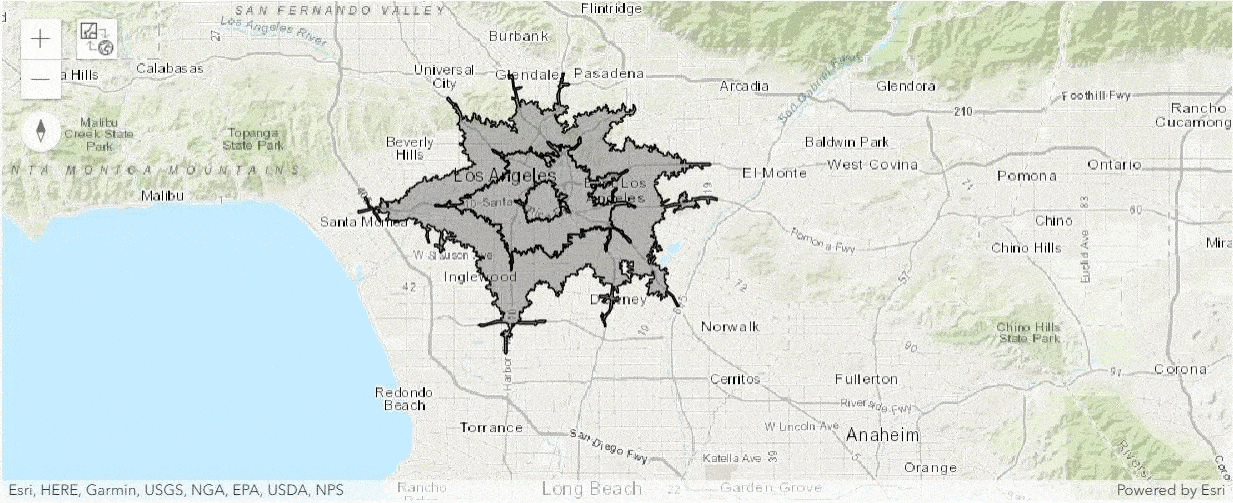

In [1]:
map2= my_gis.map("Los Angeles, CA")
map2

In [75]:
import time
map2.clear_graphics()

times = ['6 am', '10 am', '2 pm', '6 pm', '10 pm']
j=0
time.sleep(2)

for fset in LA_fset_list:
    print(times[j])
    map2.draw(fset)
    j+=1
    time.sleep(1)

6 am
10 am
2 pm
6 pm
10 pm


Thus from the animation above, we notice the service area is smallest at 6 AM and increases progressively later during the day.